！ fp, fn 写反了 已改


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score, cohen_kappa_score, precision_recall_curve)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix


In [3]:
def opt_auc_save_patient(test_log_dir, fold, label, predict, curve_auc):

    fpr, tpr, _ = roc_curve(label, predict)
    ## opt AUC curve
    line_width = 1  # 曲线的宽度
    print(f'AUC = {round(curve_auc, 4)}')
    plt.figure(figsize=(8, 5))  # 图的大小
    plt.plot(fpr, tpr, lw=line_width, label=f'AUC = {round(curve_auc, 4)}', color='red')
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.savefig(f'{test_log_dir}patientlevel_ROC_fold{fold}.jpg' , dpi=256)#bbox_inches='tight', pad_inches=0, 

## resemble evaluation


### Step 2. 计算方法1： 计算病人block预测概率均值

- 读取test block级别预测概率 pred.csv

- 读取根据val计算出的各个fold的最佳阈值 result.csv

！ 请检查测试集数据没有被打乱且每个病人均有12个block，否则需要修改


In [14]:
import os
# check！
experiment_name = 's12_block96_maskedTrue_es50_2023-02-09T09:11:18'
# experiment_name = 's12_block128_maskedTrue_es50_2023-02-05T09:42:27'
# experiment_name = 's12_block160_maskedTrue_es50_2023-02-13T22:47:06'
# experiment_name = 's12_block64_maskedTrue_es50_2023-02-24T09:50:32'

# load pred probability
path = f'/mnt/ExtData/pahsos/classification/log/{experiment_name}/test/test_block_pred.csv'
df = pd.read_csv(path)
name = np.array(df['name'])
label = np.array(df['label'])
pred = np.stack((df['pred0'], df['pred1'], df['pred2'], df['pred3'], df['pred4']), axis=1)
all = np.array(df)

save_path = f'/mnt/ExtData/pahsos/classification/log/{experiment_name}/test_new/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [6]:
## 
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR

    Youden_index = np.argmax(y)  # Only the first occurrence is returned.

    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

exp1_path = '/mnt/ExtData/pahsos/classification/log/s12_block64_maskedTrue_es50_2023-02-24T09:50:32/test/'
exp2_path = '/mnt/ExtData/pahsos/classification/log/s12_block96_maskedTrue_es50_2023-02-09T09:11:18/test/'
exp3_path = '/mnt/ExtData/pahsos/classification/log/s12_block128_maskedTrue_es50_2023-02-05T09:42:27/test/'
exp4_path = '/mnt/ExtData/pahsos/classification/log/s12_block160_maskedTrue_es50_2023-02-13T22:47:06/test/'

block_size = [64, 96, 128, 160]
exps = [exp1_path, exp2_path, exp3_path, exp4_path]   

given_thresh = 0.1596

for exp_idx, experiment_name in enumerate(exps):
    path = f'{experiment_name}test_block_pred.csv'
    df = pd.read_csv(path)
    name = np.array(df['name'])
    label = np.array(df['label'])
    pred = np.stack((df['pred0'], df['pred1'], df['pred2'], df['pred3'], df['pred4']), axis=1)
    all = np.array(df)

    avg_pred = np.mean(pred, axis=1)
    patient_avg_pred_all = []
    patient_label_all = []
    patient_name_all = [] 

    for i in range(len(name)):
        if i % 12 ==0:
            patient_name = name[i]
            patient_label_all.append(label[i])
            # print(patient_name)
            patient_name_all.append(patient_name)
            patient_pred = 0
        else:
            assert name[i] == patient_name
            patient_pred += avg_pred[i]

            if i % 11 == 0:
                patient_avg_pred = patient_pred / 12
                patient_avg_pred_all.append(patient_avg_pred)

    patient_label_all = np.array(patient_label_all)
    patient_avg_pred_all = np.array(patient_avg_pred_all)

    bi_patient_avg_pred_all = np.zeros_like(patient_avg_pred_all)
    bi_patient_avg_pred_all[patient_avg_pred_all > given_thresh] = 1

    acc = accuracy_score(patient_label_all, bi_patient_avg_pred_all)
    f1 = f1_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
    pre = precision_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
    rec = recall_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
    confuse = confusion_matrix(patient_label_all, bi_patient_avg_pred_all, labels=[1,0])
    spc = confuse[1, 1]/(confuse[0, 1] + confuse[1, 1])

    auc = roc_auc_score(patient_label_all, patient_avg_pred_all)

    fpr, tpr, threshold = roc_curve(patient_label_all, patient_avg_pred_all)
    optimal_threshold, point = Find_Optimal_Cutoff(tpr, fpr, threshold)

    print(patient_avg_pred_all)
    print(patient_name_all)
    print(bi_patient_avg_pred_all)
    print(patient_label_all)


    # f = open(f"{save_path}resemble_patient.txt","a") 
    # f.write(f'auc, acc, pre, rec, spc, tp, fn, fp, tn, kappa, p0, pe, ci95, u\r\n')
    # f.write(f'{auc}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}\r\n')
    # f.close()
    # print(f'auc : {auc}, acc : {acc}, rec : {rec}, spc : {spc}')
    # print(f'{exp_idx}, {auc}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}')

# f = open(f"{save_path}resemble_patient.txt","a") 
# f.write(f'auc, acc, pre, rec, spc, tp, fn, fp, tn, kappa, p0, pe, ci95, u\r\n')
# f.write(f'{auc}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}\r\n')
# f.close()

[8.14537986e-01 2.04363221e-02 3.96627139e-02 1.43363729e-02
 3.43177989e-01 2.04994443e-02 2.12286875e-03 1.12025112e-01
 1.37014358e-02 2.43258937e-03 5.50015409e-03 1.47978211e-02
 6.67593002e-02 6.70093571e-01 2.60893815e-02 3.10046327e-02
 7.41838541e-02 1.24590186e-02 2.82603640e-01 2.19579717e-03
 1.28469901e-03 6.95335579e-04 7.99877050e-03 2.52884583e-03
 2.46723270e-02 3.85215986e-03 2.34683647e-03 4.74200493e-03
 3.61694247e-03 2.75039447e-01 1.76071039e-01 6.45884290e-02
 1.09899861e-02 8.25919304e-01 4.85390337e-01 6.22487526e-01
 6.03407926e-01]
['CHEN-YUYU', 'CHEN-ZHONGLIANG', 'CHENG-JINFEN', 'FU-LIHUA', 'HU-ZHUIFEI', 'JIA-XIANG', 'LIU-JIANLIN', 'LIU-SHENGXIU', 'MA-TAIYONG', 'WANG-JING', 'WANG-SHIQIANG', 'WU-TUANJIE', 'XIA-CHUNSAN', 'XU-ZHENNING', 'YU-HAO', 'ZHANG-CHANGJUN', 'ZHANG-JINGFENG', 'ZHANG-SUYING', 'ZHU-SHIPING', 'CAO-YANHUA', 'CHEN-WEIDONG', 'JI-WENHUA', 'JIA-GUOGUANG', 'JIANG-YONGQUAN', 'LI-DONGSHUI', 'LI-WANHUI', 'LI-ZHONG', 'ZHU-YAPING', 'ZHUANG-MUGEN', 'LU

### block level

In [6]:
avg_pred = np.mean(pred, axis=1)

bi_pred = np.zeros_like(avg_pred)
bi_pred[avg_pred > 0.5] = 1

acc = accuracy_score(label, bi_pred)
f1 = f1_score(label, bi_pred, zero_division=1)
pre = precision_score(label, bi_pred, zero_division=1)
rec = recall_score(label, bi_pred, zero_division=1)
confuse = confusion_matrix(label, bi_pred, labels=[1,0])
spc = confuse[1, 1]/(confuse[0, 1] + confuse[1, 1])

auc = roc_auc_score(label, avg_pred)

# kappa
total_num = confuse[0, 0] + confuse[1, 1] + confuse[0, 1] + confuse[1, 0]

p0 = (confuse[0, 0] + confuse[1, 1]) / total_num
pe = ((confuse[0, 0] + confuse[1, 0]) * (confuse[0, 0] + confuse[0, 1]) + (confuse[0, 1] + confuse[1, 1]) * (confuse[1, 0] + confuse[1, 1])) / (total_num * total_num)
kappa = (p0 - pe) / (1 - pe)
print(kappa)
# kappa1 = cohen_kappa_score(bi_patient_avg_pred_all, patient_label_all)

tmp = 1.96 * np.sqrt((p0)/(total_num*(1-p0)))
ci95_upper = kappa + tmp
ci95_lower = kappa - tmp

u = kappa / (np.sqrt(p0 / total_num))

print(f'auc : {auc}, acc : {acc}, rec : {rec}, spc : {spc}')

# f = open(f"{save_path}resemble_block.txt","a") 
# f.write(f'auc, acc, pre, rec, spc, tp, fp, fn, tn, kappa, p0, pe, ci95, u\r\n')
# f.write(f'{auc}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}\r\n')
# f.close()


0.5893037336024217
auc : 0.8962823275862069, acc : 0.8513513513513513, rec : 0.75, spc : 0.9272727272727272


### patient level

In [15]:

given_thresh = 0.1596
avg_pred = np.mean(pred, axis=1)
patient_avg_pred_all = []
patient_label_all = []

for i in range(len(name)):
    if i % 12 ==0:
        patient_name = name[i]
        patient_label_all.append(label[i])
        # print(patient_name)
        patient_pred = 0
    else:
        assert name[i] == patient_name
        patient_pred += avg_pred[i]

        if i % 11 == 0:
            patient_avg_pred = patient_pred / 12
            patient_avg_pred_all.append(patient_avg_pred)

patient_label_all = np.array(patient_label_all)
patient_avg_pred_all = np.array(patient_avg_pred_all)

bi_patient_avg_pred_all = np.zeros_like(patient_avg_pred_all)
bi_patient_avg_pred_all[patient_avg_pred_all > given_thresh] = 1

acc = accuracy_score(patient_label_all, bi_patient_avg_pred_all)
f1 = f1_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
pre = precision_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
rec = recall_score(patient_label_all, bi_patient_avg_pred_all, zero_division=1)
confuse = confusion_matrix(patient_label_all, bi_patient_avg_pred_all, labels=[1,0])
spc = confuse[1, 1]/(confuse[0, 1] + confuse[1, 1])

auc = roc_auc_score(patient_label_all, patient_avg_pred_all)
print(bi_patient_avg_pred_all)
# kappa
total_num = confuse[0, 0] + confuse[1, 1] + confuse[0, 1] + confuse[1, 0]

p0 = (confuse[0, 0] + confuse[1, 1]) / total_num
pe = ((confuse[0, 0] + confuse[1, 0]) * (confuse[0, 0] + confuse[0, 1]) + (confuse[0, 1] + confuse[1, 1]) * (confuse[1, 0] + confuse[1, 1])) / (total_num * total_num)
kappa = (p0 - pe) / (1 - pe)
print(kappa)
# kappa1 = cohen_kappa_score(bi_patient_avg_pred_all, patient_label_all)

tmp = 1.96 * np.sqrt((p0)/(total_num*(1-p0)))
ci95_upper = kappa + tmp
ci95_lower = kappa - tmp

u = kappa / (np.sqrt(p0 / total_num))

# print(f'auc : {auc}, acc : {acc}, rec : {rec}, spc : {spc}')
print(f'{auc}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}')

# f = open(f"{save_path}resemble_patient.txt","a") 
# f.write(f'auc, acc, pre, rec, spc, tp, fn, fp, tn, kappa, p0, pe, ci95, u\r\n')
# f.write(f'{auc}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}\r\n')
# f.close()

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1.]
0.5612648221343873
0.8318965517241379, 0.8378378378378378, 0.6, 0.75, 0.9259259259259259, 6, 2, 4, 25, 0.5612648221343873, 0.8378378378378378, 0.6303871439006574, [-0.17115557602478437, 1.293685220293559], 3.729827102168677


- find optimal thresh 

[0.32       0.29166667 0.30434783 0.31818182 0.33333333 0.35
 0.36842105 0.38888889 0.41176471 0.4375     0.46666667 0.5
 0.46153846 0.5        0.54545455 0.6        0.55555556 0.5
 0.57142857 0.66666667 0.6        0.5        0.33333333 0.5
 1.         1.        ]
[1.    0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.75  0.75  0.75  0.75  0.625 0.5   0.5   0.5   0.375 0.25  0.125 0.125
 0.125 0.   ]


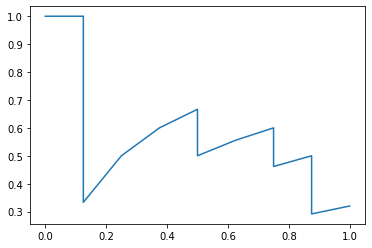

<Figure size 432x288 with 0 Axes>

In [75]:
precision, recall, thresholds = precision_recall_curve(patient_label_all, patient_avg_pred_all)
print(precision)
print(recall)
plt.figure(1)
plt.plot(recall, precision)
plt.show()
plt.savefig('{save_path}pr.png')

In [50]:
precision, recall, thresholds = precision_recall_curve(patient_label_all, patient_avg_pred_all)

f = open(f"{save_path}resemble_patient_optthresh.txt","a") 
f.write(f'thresh, auc, acc, pre, rec, spc, tp, fn, fp, tn, kappa, p0, pe, ci95, u\r\n')

for i in range(thresholds.shape[0]):
    try_thresh = thresholds[i]

    opt_bi_pred = patient_avg_pred_all.copy()
    opt_bi_pred[patient_avg_pred_all > try_thresh] = 1
    opt_bi_pred[patient_avg_pred_all <= try_thresh] = 0

    opt_acc = accuracy_score(patient_label_all, opt_bi_pred)
    opt_f1 = f1_score(patient_label_all, opt_bi_pred, zero_division=1)
    opt_pre = precision_score(patient_label_all, opt_bi_pred, zero_division=1)
    opt_rec = recall_score(patient_label_all, opt_bi_pred, zero_division=1)
    opt_confuse = confusion_matrix(patient_label_all, opt_bi_pred, labels=[1,0])
    opt_spc = opt_confuse[1, 1]/(opt_confuse[0, 1] + opt_confuse[1, 1])
    
    auc = roc_auc_score(patient_label_all, patient_avg_pred_all)

    # kappa
    total_num = opt_confuse[0, 0] + opt_confuse[1, 1] + opt_confuse[0, 1] + opt_confuse[1, 0]

    p0 = (opt_confuse[0, 0] + opt_confuse[1, 1]) / total_num
    pe = ((opt_confuse[0, 0] + opt_confuse[1, 0]) * (opt_confuse[0, 0] + opt_confuse[0, 1]) + (opt_confuse[0, 1] + opt_confuse[1, 1]) * (opt_confuse[1, 0] + opt_confuse[1, 1])) / (total_num * total_num)
    kappa = (p0 - pe) / (1 - pe)
    # kappa1 = cohen_kappa_score(bi_patient_avg_pred_all, patient_label_all)

    tmp = 1.96 * np.sqrt((p0)/(total_num*(1-p0)))
    ci95_upper = kappa + tmp
    ci95_lower = kappa - tmp

    u = kappa / (np.sqrt(p0 / total_num))

    print(f'thresh : {try_thresh}, acc : {opt_acc}, rec : {opt_rec}, spc : {opt_spc}')
    f.write(f'{try_thresh}, {auc}, {opt_acc}, {opt_pre}, {opt_rec}, {opt_spc}, {opt_confuse[0, 0]}, {opt_confuse[0, 1]}, {opt_confuse[1, 0]}, {opt_confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}\r\n')
f.close()


thresh : 0.010989986101333333, acc : 0.5135135135135135, rec : 0.875, spc : 0.9230769230769231
thresh : 0.0124590186384275, acc : 0.5405405405405406, rec : 0.875, spc : 0.9285714285714286
thresh : 0.013701435805855804, acc : 0.5675675675675675, rec : 0.875, spc : 0.9333333333333333
thresh : 0.014336372891871408, acc : 0.5945945945945946, rec : 0.875, spc : 0.9375
thresh : 0.014797821058195, acc : 0.6216216216216216, rec : 0.875, spc : 0.9411764705882353
thresh : 0.020436322050554293, acc : 0.6486486486486487, rec : 0.875, spc : 0.9444444444444444
thresh : 0.020499444339501415, acc : 0.6756756756756757, rec : 0.875, spc : 0.9473684210526315
thresh : 0.024672326969999995, acc : 0.7027027027027027, rec : 0.875, spc : 0.95
thresh : 0.026089381484600004, acc : 0.7297297297297297, rec : 0.875, spc : 0.9523809523809523
thresh : 0.031004632668369735, acc : 0.7567567567567568, rec : 0.875, spc : 0.9545454545454546
thresh : 0.03966271387060056, acc : 0.7837837837837838, rec : 0.875, spc : 0.9565

## visualization

In [66]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.metrics import auc, roc_curve

exp1_path = '/mnt/ExtData/pahsos/classification/log/s12_block64_maskedTrue_es50_2023-02-24T09:50:32/test'
exp2_path = '/mnt/ExtData/pahsos/classification/log/s12_block96_maskedTrue_es50_2023-02-09T09:11:18/test/'
exp3_path = '/mnt/ExtData/pahsos/classification/log/s12_block128_maskedTrue_es50_2023-02-05T09:42:27/test/'
exp4_path = '/mnt/ExtData/pahsos/classification/log/s12_block160_maskedTrue_es50_2023-02-13T22:47:06/test/'

block_size = [64, 96, 128, 160]
exps = [exp1_path, exp2_path, exp3_path, exp4_path]    
color = ['orange', 'blue', 'green', 'red']


#### block level

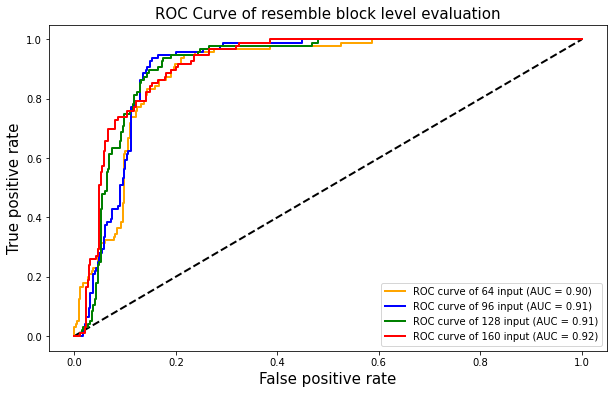

In [64]:
plt.figure(figsize=(10, 6))
plt.title(f'ROC Curve of resemble block level evaluation', fontdict={"family": "Times New Roman", "size": 15})
plt.plot([0, 1], [0, 1], lw=2, color='black', linestyle="--")
plt.xlabel('False positive rate', fontdict={"family": "Times New Roman", "size": 15})
plt.ylabel('True positive rate', fontdict={"family": "Times New Roman", "size": 15})

for i, path in enumerate(exps):
    block_pred_info = pd.read_csv(os.path.join(path, 'test_block_pred.csv'))

    label = block_pred_info['label']
    pred = np.stack((block_pred_info['pred0'], block_pred_info['pred1'], block_pred_info['pred2'], block_pred_info['pred3'], block_pred_info['pred4']), axis=1)
    avg_pred = np.mean(pred, axis=1)
    fpr, tpr, _ = roc_curve(label, avg_pred)
    plt.plot(fpr, tpr, lw=2, color=color[i], label=f'ROC curve of {block_size[i]} input (AUC = %0.2f)' % auc(fpr, tpr))

    plt.grid()  # 在图中添加网格

    plt.legend(loc="lower right") 
plt.savefig(os.path.join('/mnt/ExtData/pahsos/classification/fig', f'5in1_ROC_blocklevel_resemble.jpg'), dpi=256)


### patient level

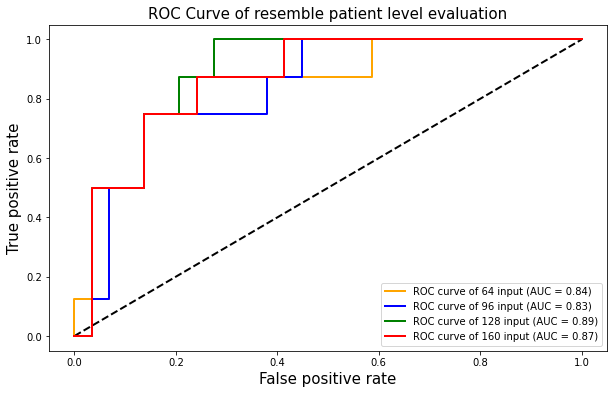

In [70]:
plt.figure(figsize=(10, 6))
plt.title(f'ROC Curve of resemble patient level evaluation', fontdict={"family": "Times New Roman", "size": 15})
plt.plot([0, 1], [0, 1], lw=2, color='black', linestyle="--")
plt.xlabel('False positive rate', fontdict={"family": "Times New Roman", "size": 15})
plt.ylabel('True positive rate', fontdict={"family": "Times New Roman", "size": 15})

for j, path in enumerate(exps):
    block_pred_info = pd.read_csv(os.path.join(path, 'test_block_pred.csv'))

    label = block_pred_info['label']
    pred = np.stack((block_pred_info['pred0'], block_pred_info['pred1'], block_pred_info['pred2'], block_pred_info['pred3'], block_pred_info['pred4']), axis=1)
    
    avg_pred = np.mean(pred, axis=1)
    patient_avg_pred_all = []
    patient_label_all = []

    for i in range(len(name)):
        if i % 12 ==0:
            patient_name = name[i]
            patient_label_all.append(label[i])
            # print(patient_name)
            patient_pred = 0
        else:
            assert name[i] == patient_name
            patient_pred += avg_pred[i]

            if i % 11 == 0:
                patient_avg_pred = patient_pred / 12
                patient_avg_pred_all.append(patient_avg_pred)

    patient_label_all = np.array(patient_label_all)
    patient_avg_pred_all = np.array(patient_avg_pred_all)

    fpr, tpr, _ = roc_curve(patient_label_all, patient_avg_pred_all)
    plt.plot(fpr, tpr, lw=2, color=color[j], label=f'ROC curve of {block_size[j]} input (AUC = %0.2f)' % auc(fpr, tpr))

    plt.grid()  # 在图中添加网格

    plt.legend(loc="lower right") 
plt.savefig(os.path.join('/mnt/ExtData/pahsos/classification/fig', f'5in1_ROC_patientlevel_resemble.jpg'), dpi=256)
